In [2]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

## Data Wrangling

### Create and Verify Database

In [3]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [4]:
ingest_create_athena_db_passed = False

In [5]:
# Set db name
database_name = "crops"

In [6]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [7]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [8]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [9]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default


In [10]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [11]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"


In [12]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [13]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


### Convert to Parquet - Haven't got this to work, may be worth exploring to reduce costs

In [315]:
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['item']) AS
SELECT area,
        item,
        year,
        production,
        nitrogen,
        phosphate,
        potassium,
        value,
        avg_rain,
        avg_temp,
        total_value_usd  
FROM {}.{}""".format(
    database_name, table_name_parquet, s3_path_parquet, database_name, table_name_csv
)

pd.read_sql(statement, conn)

Failed to execute query.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyathena/common.py", line 305, in _execute
    **request
  File "/opt/conda/lib/python3.7/site-packages/pyathena/util.py", line 84, in retry_api_call
    return retry(func, *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tenacity/__init__.py", line 379, in __call__
    do = self.iter(retry_state=retry_state)
  File "/opt/conda/lib/python3.7/site-packages/tenacity/__init__.py", line 314, in iter
    return fut.result()
  File "/opt/conda/lib/python3.7/concurrent/futures/_base.py", line 428, in result
    return self.__get_result()
  File "/opt/conda/lib/python3.7/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
  File "/opt/conda/lib/python3.7/site-packages/tenacity/__init__.py", line 382, in __call__
    result = fn(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/botocore/client.py", line 530, in _api_call
    return

DatabaseError: Execution failed on sql: CREATE EXTERNAL TABLE IF NOT EXISTS crops.merged_df_parquet
WITH (format = 'PARQUET', external_location = 's3://sagemaker-us-east-1-998234604495/merged_df/parquet', partitioned_by = ARRAY['item']) AS
SELECT area,
        item,
        year,
        production,
        nitrogen,
        phosphate,
        potassium,
        value,
        avg_rain,
        avg_temp,
        total_value_usd  
FROM crops.merged_df
An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: line 1:8: mismatched input 'EXTERNAL'. Expecting: 'OR', 'SCHEMA', 'TABLE', 'VIEW'
unable to rollback

# Exploratory Data Analysis

In [14]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)
df.head()

,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Japan,Peas green,1991,52400.0,576000.0,696000.0,480000.0,5424.4,1668.0,13.32,284238560.0
1,Japan,Peas green,1991,52400.0,576000.0,696000.0,480000.0,5424.4,1668.0,15.43,284238560.0
2,Japan,Peas green,1991,52400.0,576000.0,696000.0,480000.0,5424.4,1668.0,15.38,284238560.0
3,Japan,Peas green,1991,52400.0,576000.0,696000.0,480000.0,5424.4,1668.0,15.49,284238560.0
4,Japan,Peas green,1991,52400.0,576000.0,696000.0,480000.0,5424.4,1668.0,13.32,284238560.0


## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

In [1]:
sns.set(style = "darkgrid")
sns.distplot(a = df['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

NameError: name 'sns' is not defined

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

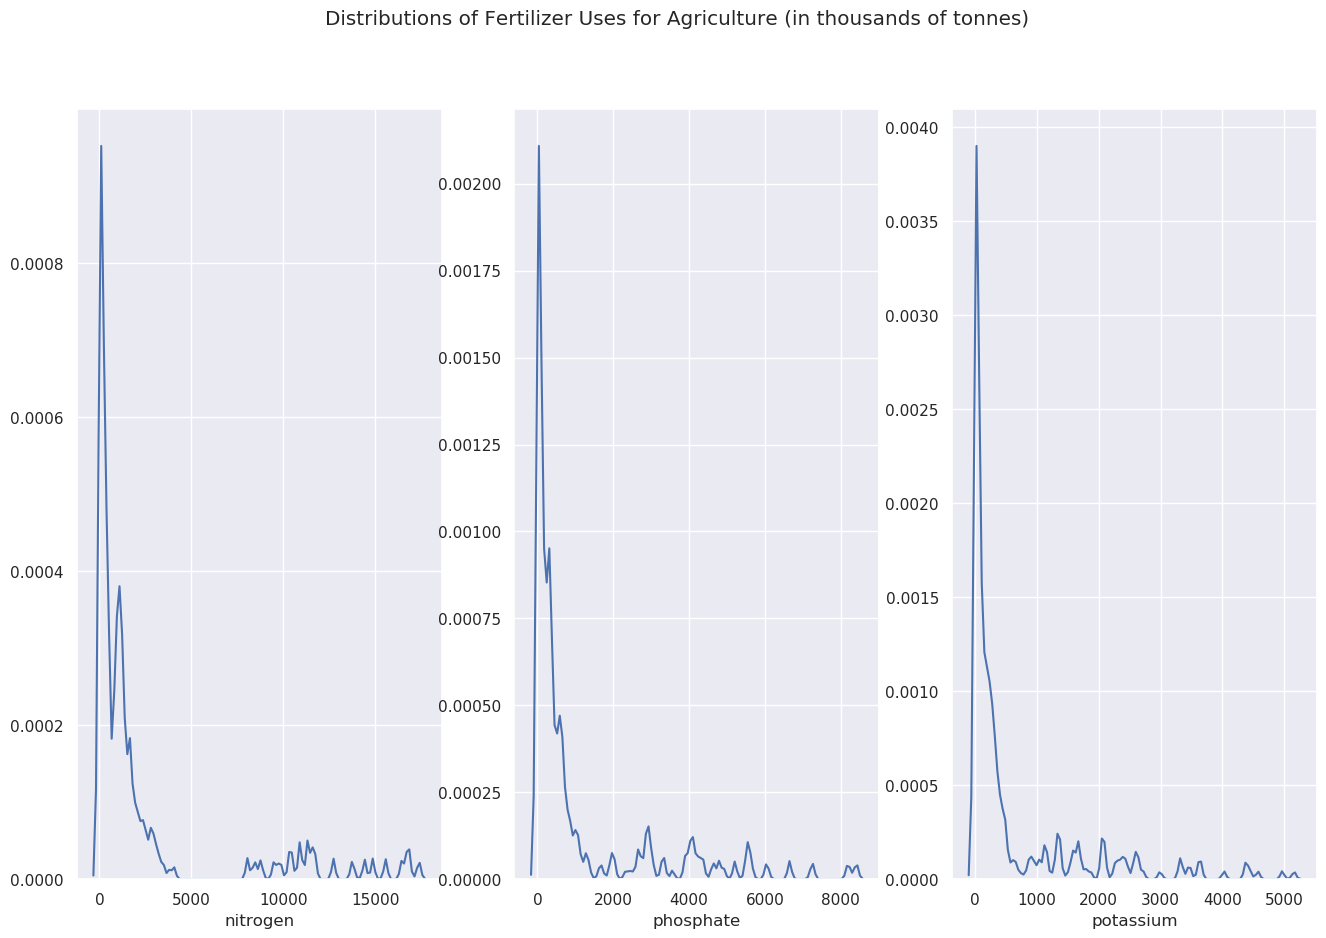

In [16]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


Fertilizer Relationships with Target - Correlation Matrix is probably better option

Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

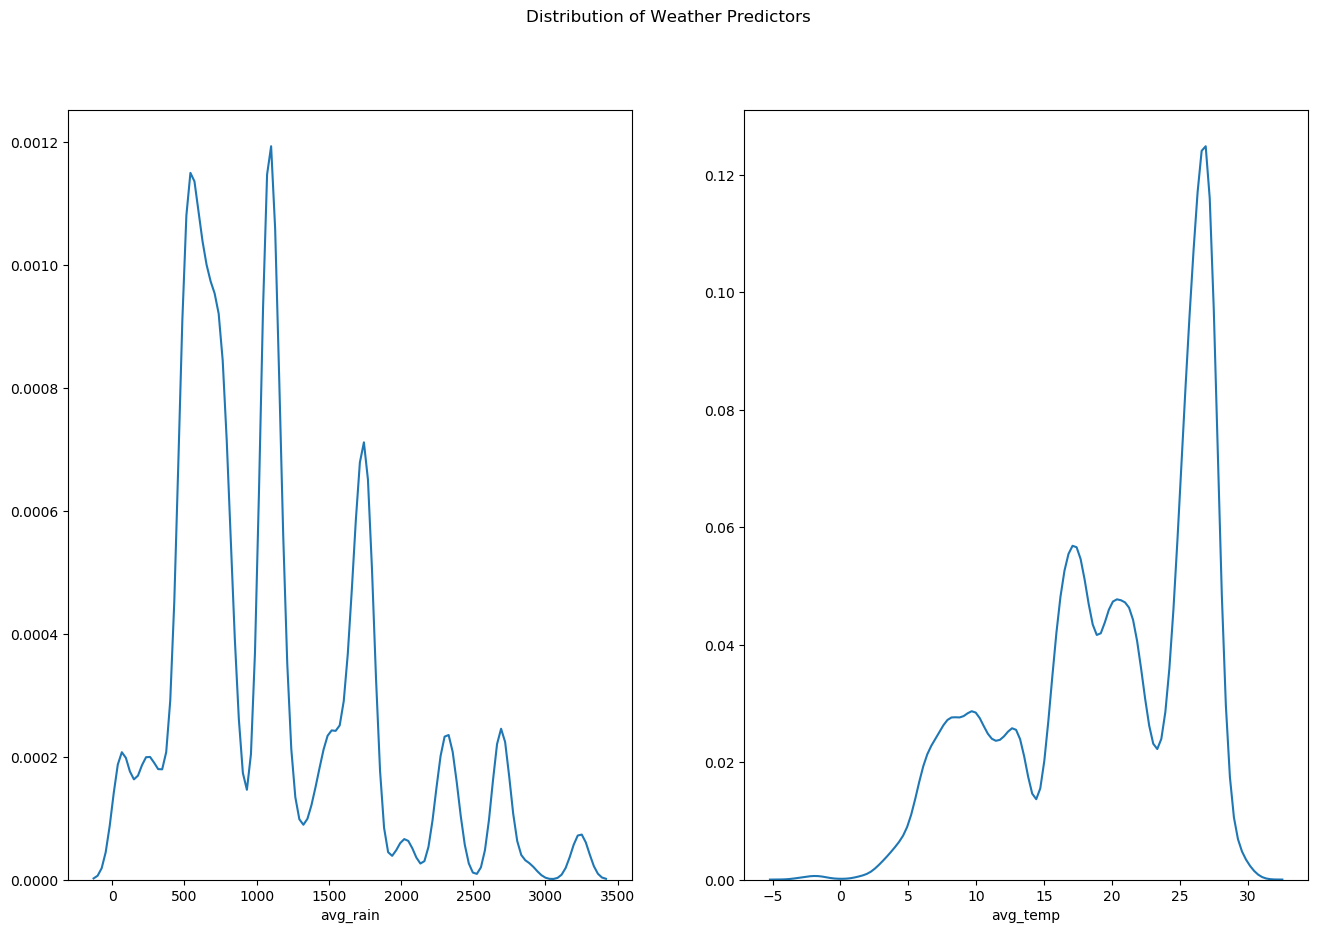

In [17]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

Correlation Matrix for Numeric Features

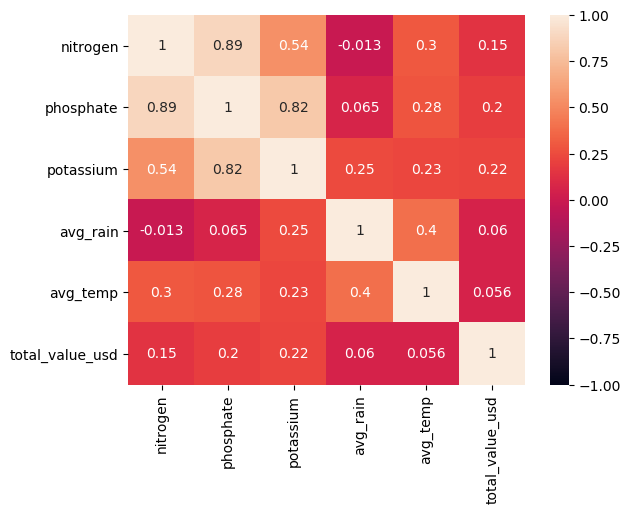

In [20]:
df_numeric = df.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()